# IMPORTS

In [1]:
from skimage import io
import numpy as np
from Utilities import show_images
from skimage.color import rgb2ycbcr
import cv2
from sklearn.cluster import KMeans

%load_ext autoreload
%autoreload 2
%matplotlib inline


# Algorithm-1

Kmeans

In [ ]:
def gammaCorrection(src, gamma):
    invGamma = 1 / gamma
    table = [((i / 255) ** invGamma) * 255 for i in range(256)]
    table = np.array(table, np.uint8)
    return cv2.LUT(src, table)

def blackout(frame,gray):
    '''
    Removes the face from the passed frame using haar cascades
    '''
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray,1.2,1)
    for (x,y,w,h) in faces:
        #Blacking out the face
        new_face = np.copy(frame[y+int(h*0.2):y+h-int(h*0.2),x+int(w*0.2):x+w-int(w*0.2)])
        frame[y-50:y+h+50,x:x+w] = 0
    return frame, new_face
    
def k_means(img):

    kmeans = KMeans(n_clusters=2)
    x, y, z = img.shape
    img2d = img.reshape(x*y, z)

    kmeans.fit(img2d)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    max = np.argmax(np.bincount(labels))

    # img2d_temp=np.copy(img2d)
    # for i in range (img2d_temp.shape[0]):
    #     img2d_temp[i]=centers[labels[i]]
    # image_final=img2d_temp.reshape(x,y,z)
    # return centers,labels,image_final,max
    return centers,labels,max

In [ ]:
def SkinDetection_KMeans(image):

    gammaImg = gammaCorrection(image,1)
    gray_img = cv2.cvtColor(gammaImg,cv2.COLOR_BGR2GRAY)
    _, face= blackout(gammaImg,gray_img)

    centers,_,_=k_means(face)

    if ((centers[1][0]-centers[0][0])>0):
        skin=cv2.inRange(image,centers[0],centers[1])
    else:
        skin=cv2.inRange(image,centers[1],centers[0])

    return skin

# Algorithm-2

Multi-Scale Skin Detection

In [19]:
def SkinDetection_Multiscale(image):

    red = np.copy(image[:,:,0]).astype(np.int16)
    green = np.copy(image[:,:,1]).astype(np.int16)
    blue = np.copy(image[:,:,2]).astype(np.int16)

    ############### NORMALIZED RGB
    red_dash = red/(red+green+blue)
    green_dash = green/(red+green+blue)
    blue_dash = blue/(red+green+blue)

    ############### HSV
    value = np.maximum.reduce([red_dash,green_dash,blue_dash])
    minimum = np.minimum.reduce([red_dash,green_dash,blue_dash])

    saturation = np.zeros(red_dash.shape)
    saturation[value!=0] = (value[value!=0] - minimum[value!=0] ) / value[value!=0]

    hue = np.zeros(red_dash.shape)

    hue[value == red] = ((60*(green_dash-blue_dash)) / (value-minimum))[value == red]
    hue[value == green] = (2+ (60*(blue_dash-red_dash)/(value-minimum)))[value == green]
    hue[value == blue] = (4+ (60*(red_dash-green_dash)/(value-minimum)))[value == blue]

    hue[hue<0] = hue[hue<0] + 360
    ############### YCBCR
    ycbcr_image = rgb2ycbcr(image)
    y = ycbcr_image[:,:,0]
    cb = ycbcr_image[:,:,1]
    cr = ycbcr_image[:,:,2]

    new_img = np.zeros(red_dash.shape).astype(np.uint8)
    # for row in range(0, image.shape[0]):
    #     for column in range(0, image.shape[1]):

    #         if(red_dash[row][column]/green_dash[row][column] > 1.185 ):

    #             if(hue[row][column] >=0 and hue[row][column] <= 25) or (hue[row][column] >= 335 and hue[row][column] <= 360):

    #                 if(saturation[row][column] >= 0.2 and saturation[row][column] <= 0.6):

    #                     if(cb[row][column] > 77 and cb[row][column] < 127):

    #                         if(cr[row][column] > 133 and cb[row][column] < 173):

    #                             new_img[row][column] = 255     
    # show_images([new_img])
    #check = red_dash/green_dash > 1.185 and cb > 77 and cb < 127 and cr > 133 and cb < 173 and saturation >= 0.2 and saturation<= 0.6 and (hue >=0 and hue <= 25 or hue >= 335 and hue <= 360)
    check = np.bitwise_and(red_dash/green_dash > 1.185, np.bitwise_and(cb > 77, np.bitwise_and(cb < 127,np.bitwise_and(cr > 133, np.bitwise_and(cb < 173 , np.bitwise_and(saturation >= 0.2 , np.bitwise_and(saturation<= 0.6 , np.bitwise_and(hue >=0 , np.bitwise_and( hue <= 25 , np.bitwise_or(hue >= 335 , hue <= 360))))))))))
    new_img[check] = 255   

    return new_img

E:\Anaconda3\envs\pattern\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
E:\Anaconda3\envs\pattern\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
E:\Anaconda3\envs\pattern\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
E:\Anaconda3\envs\pattern\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
E:\Anaconda3\envs\pattern\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
E:\Anaconda3\envs\pattern\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
E:\Anaconda3\envs\pattern\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in true_divide
E:\Anaconda3\envs\pattern\

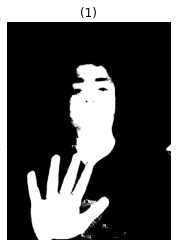

In [20]:
image = io.imread('100100.jpg')
# show_images([image])
skin = SkinDetection_Multiscale(image)
show_images([skin])

# Algorithm3

InRange

In [ ]:
def SkinDetection_InRange(img):
    
    img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    HSV_mask = cv2.inRange(img_HSV, (0, 15, 0), (17,170,255)) 
    HSV_mask = cv2.morphologyEx(HSV_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

    img_YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    YCrCb_mask = cv2.inRange(img_YCrCb, (0, 135, 85), (255,180,135)) 
    YCrCb_mask = cv2.morphologyEx(YCrCb_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

    global_mask=cv2.bitwise_and(YCrCb_mask,HSV_mask)
    global_mask=cv2.medianBlur(global_mask,3)
    global_mask = cv2.morphologyEx(global_mask, cv2.MORPH_OPEN, np.ones((4,4), np.uint8))

    return global_mask

# Voting System

Anding Output of the three algorthims together

In [ ]:
filename = "100100.jpg"
image = io.imread(filename)
cv2_image = cv2.imread(filename)

one = SkinDetection_InRange(cv2_image)
two = SkinDetection_Multiscale(image)
three = SkinDetection_KMeans(image)

final_1 = cv2.bitwise_and(one,two)
# final = cv2.bitwise_and(final_1,three)
show_images([one, two, three, final_1])

# _, hand = faceDetectionAndRemoval(final_1)
show_images([final_1])